In [1]:
import numpy as np
import pandas as pd
import plotly
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles
import seaborn as sns
import imp
import matrixes
imp.reload(matrixes)

<module 'matrixes' from 'C:\\Users\\ALemikhov\\Documents\\Slb research\\01_ResModel\\matrixes.py'>

# Reservoir model

Задача - построить 2D модель резервуара. Для начала необходимо задать свойства полости, такие как $\phi,\ S_{water}, S_{oil} = 1 - S_{water}, c_r, c$. Также величины, фигурирующие в законе Дарси: $k, \mu, \rho$. Будем считать модель изотропной и варьировать лишь $S_{oil}$

# Построение формы резервуара
## Насыщение
Будем задавать значения каким -нибудь рандомным способом, но красивым. В `sklearn` есть множество методов создания выборок для классификации, мне понравился этот. Так мы и будем определять где вода, а где нефть.

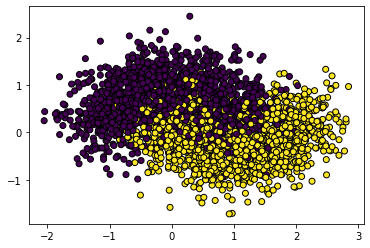

In [2]:
ds = matrixes.get_saturation_scattered(n_samples=3000, noise=0.4)
plt.scatter(ds[0][:, 0],ds[0][:, 1], c=ds[1], edgecolors='k')
plt.show()          

Перенесём всё это на меньший сетку фиксированного размера c фиксированным шагом по следующим правилам
<ol>
<li>Если в ячейке не оказывается ни одного элемента - значит это не пористая структура.

<li>Если оказывается несколько - берёс среднее арифметическое
</ol>

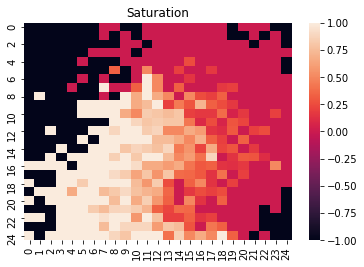

In [3]:
Satur_matrix = matrixes.get_grid_from_scattered(ds=ds)
sns.heatmap(Satur_matrix)
plt.title("Saturation")
plt.show()

# Глубина
Покачто у нас резервуар 2D и вид сверху, нужно задать функцию глубины.

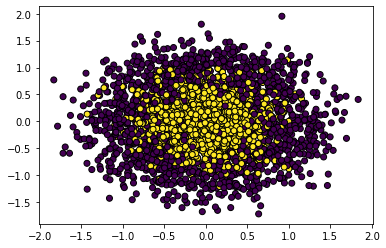

In [4]:
ds = matrixes.get_depth_scattered(n_samples=3000)
plt.scatter(ds[0][:, 0],ds[0][:, 1], c=ds[1], edgecolors='k')
plt.show()    

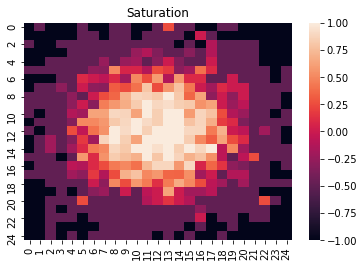

In [5]:
depth_matrix = matrixes.get_grid_from_scattered(ds=ds)
sns.heatmap(depth_matrix)
plt.title("Saturation")
plt.show()

# Пористость
Возьмём её пока такую же как матрицу проницаемости

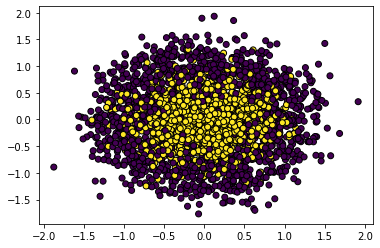

In [6]:
ds = matrixes.get_depth_scattered(n_samples=3000)
plt.scatter(ds[0][:, 0],ds[0][:, 1], c=ds[1], edgecolors='k')
plt.show()   

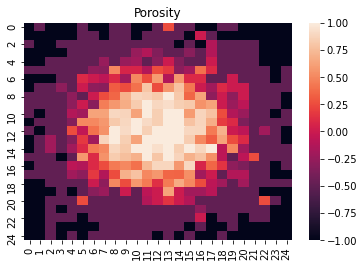

In [7]:
porosity_matrix = matrixes.get_grid_from_scattered(ds=ds)
sns.heatmap(depth_matrix)
plt.title("Porosity")
plt.show()

# Проницаемость k
Возьмём такую же как матрицу насыщений

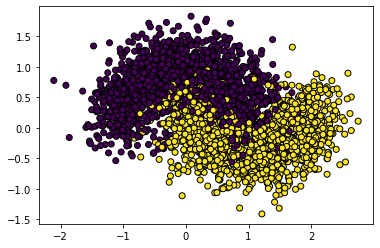

In [8]:
ds = matrixes.get_saturation_scattered(n_samples=3000, noise=0.3)
plt.scatter(ds[0][:, 0],ds[0][:, 1], c=ds[1], edgecolors='k')
plt.show()     

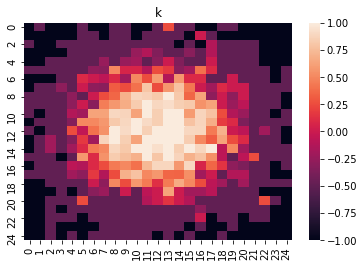

In [9]:
k_matrix = matrixes.get_grid_from_scattered(ds=ds)
sns.heatmap(depth_matrix)
plt.title("k")
plt.show()

## Матрицы свойств собраны
Для построения модели эти матрицы нужно вытянуть в матрицы размера $n_x \cdot n_y$, сделать около диагональными и уметь обращаться к свойствам резервуара на границе ячеек для матриц $k$ и $depth$

Для $k$ в лекции вывели формулу, её реализаия представлена в классе `KMatrix`. 

$$k_{i+\frac{1}{2}, j} = \frac{\Delta x_{i, j} + \Delta y_{i+1, j}}{\frac{\Delta x_{i, j}}{k_{i, j}} + \frac{\Delta x_{i+1, j}}{k_{i+1, j}}}$$
\
\
$$k_{i, j+\frac{1}{2}} = \frac{\Delta y_{i, j} + \Delta y_{i, j+1}}{\frac{\Delta y_{i, j}}{k_{i, j}} + \frac{\Delta y_{i, j+1}}{k_{i, j+1}}}$$

Приведу небольшой тест для пояснения

In [10]:
from matrixes import KMatrix
k_matrix = KMatrix(k_values=np.array([[1, 2, 3, 5, 7],
                                      [4, 5, 6, 1, 2],
                                      [9, 5, 6, 1, 4]]),
                   dy_matrix=np.array([[1, 2, 3, 5, 7],
                                       [4, 5, 6, 1, 2],
                                       [9, 5, 6, 1, 4]]),
                   dx_matrix=np.array([[1, 2, 3, 5, 7],
                                       [4, 5, 6, 1, 2],
                                       [9, 5, 6, 1, 4]])
                   )

assert k_matrix[0.5, 1] == 3.5
assert k_matrix[1, 1] == 5

Аккуратненько реализуем 
$$d_{i,\ j+\frac{1}{2}} = \frac{d_{i, j} + d_{i, j+1}}{2}$$
\
\
$$d_{i+\frac{1}{2},\ j} = \frac{d_{i, j} + d_{i+1, j}}{2}$$

In [11]:
from matrixes import DMatrix

d_matrix = DMatrix(d_values=np.array([[1, 2, 3, 5, 7],
                                      [4, 5, 6, 1, 2],
                                      [9, 5, 6, 1, 4]]),
                   )
assert d_matrix[0.5, 2] == 4.5
assert d_matrix[2, 2.5] == 3.5
assert d_matrix[1, 1] == 5


# T-matrix
Теперь можно для каждого стыка ячеек можно указать проводимость $T_{i, j+\frac{1}{2}}$